# **给 Colab 用户的注意事项**

# **切勿直接在这个文件里写——你的进度可能会丢失！**

# **开始前一定要先复制一份。**

如何复制文件

1. 点击左上角的“File”。
> *如果你找不到上方菜单（比如“File”或“Runtime”），点右上角的“v”标志展开菜单。*

2. 选择“Save a copy in Drive”

3. 把复制的文件重命名为 “YOURNAMEs_FileName.ipynb”。
> 例如：你的名字是 Olivia，就改成 Olivias_FileName.ipynb



---

* 勾选标记（✅）不会保存。如果用 Chrome 的刷新按钮重新加载，勾选会消失。<br>
如果想暂停后再接着做，可以新建一个文本单元，写上“SO FAR DONE”之类的字样。

---

* 在 Colab 中，**之前的输出结果会每隔30到90分钟被重置一次**。<br>
  所以经常会遇到 `~~ is not defined` 之类的错误。

  🔁 遇到 `~~ is not defined` 错误怎么办
  1. 先确认变量拼写是否正确。<br>
  2. 拼写没问题但还报错，**点击你想重启的那个单元格**。<br>
  3. 点击左上“Runtime” → 选“Run before”。<br>
    → 这会**重新运行之前所有的单元格**。
  4. 再次运行该单元格。

  如果经过这些步骤仍然报错，<br>
  可能是你之前单元格里的 TODO 答案有基础错误，<br>
  请仔细检查你的答案是否正确。<br>
  也可以求助 ChatGPT 或其他编程助手。

# **Preparation**

本节仅加载之前章节的内容。<br>
直接运行代码即可，无需阅读。<br>
你也可以直接跳过这部分。<br>

In [ ]:
# 下载文件
!wget https://raw.githubusercontent.com/HayatoHongo/Everyones_nanoGPT/main/input.txt -O input.txt
# 加载刚才以 utf-8 编码下载的名为 input.text 的文件。
with open("input.txt", 'r', encoding = 'utf-8') as f:
    text = f.read()

# 一个用于美观显示张量的函数（可跳过）
import torch
import torch.nn as nn
import torch.nn.functional as F

def print_formatted_tensor(*args, width=6, decimals=2):
    """
    将英文注释、文档字符串和 print 语句简洁、友好、自然地翻译成简体中文。
    A function that neatly formats and displays a PyTorch Tensor, and also prints its size.

    Example usage:
        print_formatted_tensor("名称", tensor)
        print_formatted_tensor(tensor)

    Args:
        *args: If given 1 argument, it is treated as a tensor.
               If given 2 arguments, the first is treated as the name, the second as the tensor.
        width (int): Display width for each number (default: 6)
        decimals (int): Number of decimal places to show (default: 2)
    """
    将英文注释、文档字符串和 print 语句翻译成简体中文

    # 根据参数确定张量和名称
    if not args:
        raise ValueError("At least one argument is required.")
    if isinstance(args[0], str):
        if len(args) < 2:
            raise ValueError("Tensor is not specified.")
        name, tensor = args[0], args[1]
    else:
        name, tensor = None, args[0]

    # 将张量转换为列表
    tensor_list = tensor.detach().cpu().tolist()

    def format_list(lst, indent):
        """格式化递归嵌套列表并返回字符串"""
        # 如果内容是列表，则重新返回
        if isinstance(lst, list) and lst and isinstance(lst[0], list):
            inner = ",\n".join(" " * indent + format_list(sub, indent + 2) for sub in lst)
            return "[\n" + inner + "\n" + " " * (indent - 2) + "]"
        # 用于数字列表
        return "[" + ", ".join(f"{v:{width}.{decimals}f}" for v in lst) + "]"

    # 格式化字符串（最外层框架的花括号已移除）
    formatted = format_list(tensor_list, indent=9)
    inner_formatted = formatted[1:-1].strip()

    # 结果输出
    if name:
        print(name)
    print(f"Tensor Size: {list(tensor.size())}")
    print("张量([")
    print("" * 9 + inner_formatted)
    print("" * 7 + "])")

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        # 定义一个嵌入表，用于词汇数量 x 嵌入维度数
        self.token_embedding_table = nn.Embedding(vocab_size, embedding_dim)

    def embed(self, input_indices):
        # 获取对应输入索引的嵌入向量
        return self.token_embedding_table.forward(input_indices)

# 定义位置嵌入模块
class PositionEmbedding(nn.Module):
    def __init__(self, input_sequence_length, embedding_dim):
        super().__init__()
        # 位置嵌入层
        self.position_embedding_layer = nn.Embedding(input_sequence_length, embedding_dim)

    def forward(self, input_indices):
        sequence_length = input_indices.shape[1]  # 获取序列长度
        position_indices = torch.arange(sequence_length, device=input_indices.device)  # 位置索引生成
        position_embeddings = self.position_embedding_layer(position_indices)  # 位置嵌入
        return position_embeddings

class EmbeddingModule(nn.Module):
    def __init__(self, vocab_size, config):
        super().__init__()
        # 每个标记的嵌入层
        self.token_embedding_layer = TokenEmbedding(vocab_size = vocab_size, embedding_dim = config.embedding_dim)
        self.position_embedding_layer = PositionEmbedding(input_sequence_length = config.input_sequence_length, embedding_dim = config.embedding_dim)

    def forward(self, input_indices):
        # 获取令牌嵌入
        token_embeddings = self.token_embedding_layer.embed(input_indices)

        # 获取位置嵌入
        position_embeddings = self.position_embedding_layer.forward(input_indices)

        # 添加词元嵌入和位置嵌入
        embeddings = token_embeddings + position_embeddings
        return embeddings

class AttentionHead(nn.Module):
    def __init__(self, head_size, config):
        super().__init__()
        self.key_fc= nn.Linear(config.embedding_dim, head_size, bias=False)
        self.query_fc = nn.Linear(config.embedding_dim, head_size, bias=False)
        self.value_fc = nn.Linear(config.embedding_dim, head_size, bias=False)

        # 掩码通过下三角矩阵创建（保持自注意力的因果性）
        self.register_buffer('tril', torch.tril(torch.ones(config.input_sequence_length, config.input_sequence_length)))

        # 随机失活
        self.dropout = DeterministicDropout(config.dropout_rate)
        self.head_size = head_size

    def forward(self, input_tensor):
        B, T, C = input_tensor.shape  # 批次，令牌长度，嵌入通道

        key = self.key_fc.forward(input_tensor)     # (B, T, head_size)
        query = self.query_fc.forward(input_tensor)   # （批次大小，序列长度，头部大小）
        value = self.value_fc.forward(input_tensor)   # (B, T, head_size)

        # 计算注意力分数 (QK^T) * self.head_size **(-0.5)
        attention_scores = query @ key.transpose(-2, -1) * self.head_size**(-0.5)

        # 已应用掩码
        attention_scores = attention_scores.masked_fill(self.tril[:T, :T] == 0, float('-inf'))

        # Softmax → Dropout → 加权和
        attention_weights = F.softmax(attention_scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        out = attention_weights @ value  # (B, T, head_size)
        return out

class DeterministicDropout(nn.Module):
    def __init__(self, p=0.1, seed=199):
        super().__init__()
        self.p = p
        # 创建一个固定的随机数生成器
        self.generator = torch.Generator()
        self.generator.manual_seed(seed)

    def forward(self, x):
        if self.training:
            # 使用固定生成器生成随机数
            mask = (torch.rand(x.shape, generator=self.generator, device=x.device, dtype=x.dtype) > self.p)
            return x * mask / (1 - self.p)
        else:
            return x

class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.num_attention_heads = config.num_attention_heads
        self.embedding_dim = config.embedding_dim

        # 头部大小是嵌入维度数除以注意力头数。在这个例子中，8/2 = 4 是 self.head_size。
        self.head_size = int(self.embedding_dim / self.num_attention_heads)

        # 使用 ModuleList 管理多个头部
        self.attention_heads = nn.ModuleList([
            AttentionHead(self.head_size, config)
            for _ in range(self.num_attention_heads)
        ])

        # 用于混合每个头输出的线性层
        self.output_projection = nn.Linear(self.embedding_dim, self.embedding_dim)

        # 输出层的丢弃率
        self.dropout = DeterministicDropout(config.dropout_rate)

    def forward(self, input_tensor):
        # 获取每个头的输出
        head_outputs_list = [head(input_tensor) for head in self.attention_heads]  # (B, T, head_dim) 列表

        # 将所有头的输出拼接 → (B, T, embedding_dim)
        concatenated = torch.cat(head_outputs_list, dim=-1)

        # 混合输出与线性变换
        projected = self.output_projection(concatenated)

        # 对最终输出应用 dropout
        output = self.dropout(projected)

        return output

class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.fc1 = nn.Linear(config.embedding_dim, config.hidden_dim)  # 第一层
        self.relu = nn.ReLU()  # 激活函数
        self.fc2 = nn.Linear(config.hidden_dim, config.embedding_dim)  # 第二层全键合层
        self.dropout = DeterministicDropout(config.dropout_rate) # 丢弃法

    def forward(self, attention_output_tensor):
        hidden_tensor = self.fc1(attention_output_tensor)

        activated_tensor = self.relu(hidden_tensor)

        output_tensor = self.fc2(activated_tensor)

        final_output_tensor = self.dropout(output_tensor)

        return final_output_tensor

class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layer_norm1 = nn.LayerNorm(config.embedding_dim)
        self.layer_norm2 = nn.LayerNorm(config.embedding_dim)

        self.multihead_attention = MultiHeadAttention(config=config)
        self.feed_forward = FeedForward(config=config)

    def forward(self, input_tensor):
        normed_input = self.layer_norm1(input_tensor) # 对输入应用层归一化
        attention_output = self.multihead_attention(normed_input) # 对归一化输入应用多头注意力
        residual_attention = input_tensor + attention_output # 残差连接（将注意力的输出加到原始输入上（归一化前））
        normed_attention = self.layer_norm2(residual_attention) # 对残差输出再次应用 LayerNorm
        feedforward_output = self.feed_forward(normed_attention) # 应用前馈网络 (FFN)
        final_output = residual_attention + feedforward_output # 残差连接（将FFN的输出加到归一化前的前一个残差输出上）

        return final_output

# 存储模型设置的配置类
class ModelConfig:
    batch_size = 1  # 一次处理的数据量（批大小）
    input_sequence_length = 8  # 输入数据长度（序列长度）
    embedding_dim = 8  # 嵌入层大小（特征向量的维度数）
    hidden_dim = 16 # FeedForward 层中隐藏层的大小
    num_attention_heads = 2  # 注意机制头数
    dropout_rate = 0.1  # 丢弃概率

# 我只是把目前为止的流程整理了一下，这样我就可以跳过它了
torch.manual_seed(1337)

# 创建一个 ModelConfig 实例。没有配置参数（构造函数）。
config = ModelConfig()

# 创建 EmbeddingModule 实例。
embedding_module = EmbeddingModule(vocab_size = 65, config = config)

# 创建一个 Transformer 块实例。
transformer_block1 = TransformerBlock(config=config)
transformer_block2 = TransformerBlock(config=config)

# 兼容 Let's he。（批量大小，令牌长度）=（1，8）
sample_input_tokens = torch.tensor([[24, 43, 58, 5, 57, 1, 46, 43]])
sample_embeddings = embedding_module.forward(sample_input_tokens)

# 通过第一个 Transformer 块
transformer_block1_output = transformer_block1.forward(sample_embeddings)
transformer_block2_output = transformer_block2.forward(transformer_block1_output)
print_formatted_tensor("transformer_block2输出", transformer_block2_output)

# **Chapter 10: The VocabularyLogits Class**

### **Section 1: forward**

```python
Instance: output_norm = nn.LayerNorm(embedding_dim)
Argument: embedding_dim
```

- `nn.LayerNorm` 创建一个沿输入张量**最后一维**归一化的层。  
- 这里输入形状是 (B, T, C)，所以需要指定最后一维的嵌入维度 `C`。

In [ ]:
embedding_dim = 8
output_norm = # TODO: nn.LayerNorm（嵌入维度）
normalized_output = output_norm(transformer_block2_output)
print_formatted_tensor("归一化输出", normalized_output)

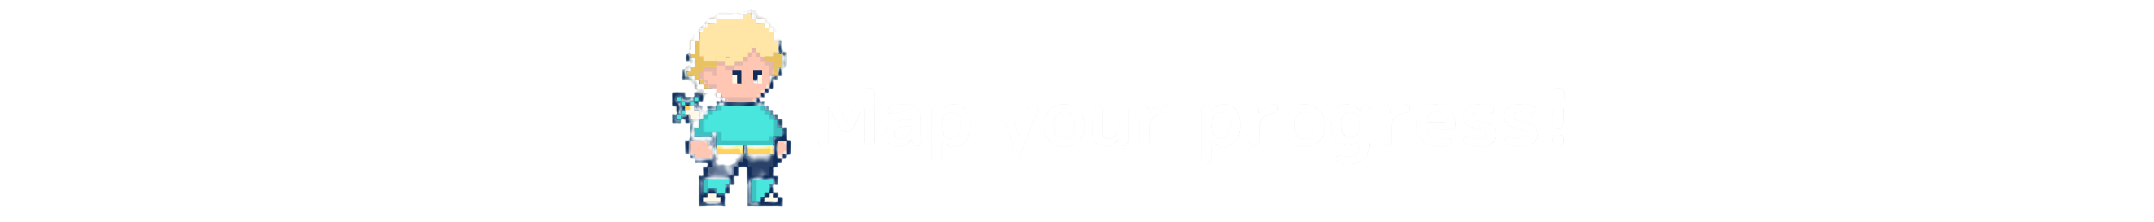

归一化发生在线性变换之前。  
由于归一化是在最后一个维度——嵌入维度上进行的，这意味着线性变换也是针对这个维度的。

归一化后的张量通过线性变换投影到“词汇表大小”。  
这会计算每个词汇的概率。

对于8个字符中的每一个，都预测下一个字符。  
65个维度中的每一个对应一个匹配的 token 的概率。

举个例子，第一个字符中，假设“A”的概率是+0.50，“B”的概率是-0.50。<br>  
这意味着第一个字符更可能是“A”。

In [ ]:
# 此代码仅运行一次。重复运行会更改随机种子，导致映射和张量不匹配。
vocab_projection = nn.Linear(8, 65)

In [ ]:
vocabulary_logits = # TODO: 实例.方法(参数)
print_formatted_tensor("词汇表logits", vocabulary_logits)

如果输出与 Canva 中 Tensor Map 的默认 `vocabulary_logits` 张量不匹配，这很可能是种子值的问题。<br>
这不是大问题，所以请继续。

**Chapter 10: VocabularyLogits Class: Section 1: forward** <label><input type="checkbox"> Mark as Done</label>

### **Section 2: Calculating Loss**

将似然转换为概率：使用 Softmax

```python
Function: torch.softmax
Arguments: vocabulary_logits, dim=THINK_FOR_YOURSELF
```

- 在词汇维度上应用 softmax。张量形状为 `(B, T, V)`<br>
输出的 `vocabulary_probabilities` 是一个张量，表示每个词汇的概率。

In [ ]:
vocabulary_probabilities = # TODO: 应用函数名（参数1，参数2）
print_formatted_tensor("词汇概率", vocabulary_probabilities)

**目标序列的 IDs**

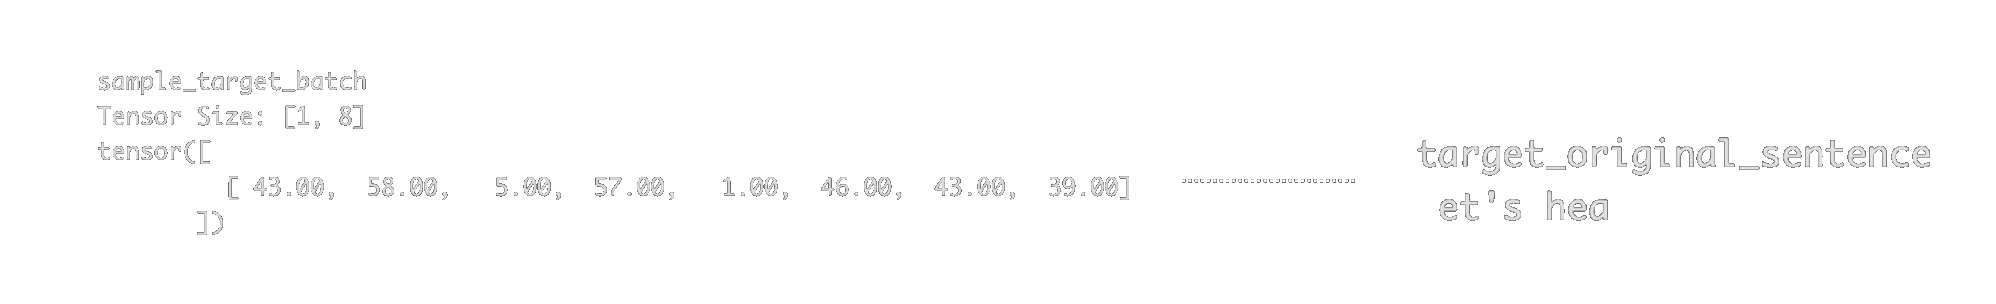

```python
Function: F.one_hot
Arg 1: target_indices (整数标签的张量)
Arg 2: num_classes = THINK_FOR_YOURSELF
```

- `F.one_hot(...)` 将整数标签转换成独热向量。

In [ ]:
target_indices = torch.tensor([[43,  58,  5,  57,  1,   46,  43,  39]])

one_hot_result = # TODO: 函数(参数)
print_formatted_tensor("独热编码结果", one_hot_result)

**计算交叉熵损失**

PyTorch 的 `nn.CrossEntropyLoss` 接收**logits（每个类别的值）**和**正确类别的索引**作为输入。<br>
它会自动对 logits 应用 softmax，然后计算预测的概率。<br>
同时，它会把正确的索引转换成 one-hot 格式后再计算交叉熵损失。<br>
所以，**不需要你自己做 softmax 或 one-hot 编码**。<br><br>

注意输入形状。PyTorch 期望的概率分布形状是：<br>
`(batch size × sequence length, vocab size)`。<br><br>
正确标签的形状应为：<br>
`(batch size × sequence length)`。<br>

如果原始数据是 `(1, 8, 65)` 这样的 3 维张量，先 reshape 成 `(1*8, 65)` 这样的 2 维张量，再传进去。

In [ ]:
vocabulary_logits_reshaped = vocabulary_logits.view(1*8, 65) # (1, 8, 65) -> (8, 65)
print_formatted_tensor("vocabulary_logits_reshaped", vocabulary_logits_reshaped)

target_indices_reshaped = target_indices.view(1*8) # (1, 8) -> (8)
print_formatted_tensor("目标索引_重塑", target_indices_reshaped)

```python
Instance: criterion
Method: forward (optional)
Argument: vocabulary_logits_reshaped, target_indices_reshaped
```
- 使用经过reshape的logits和标签作为参数，以符合Pytorch的要求。

In [ ]:
criterion = nn.CrossEntropyLoss()
loss = # TODO: 实例.方法(参数)
print(loss)

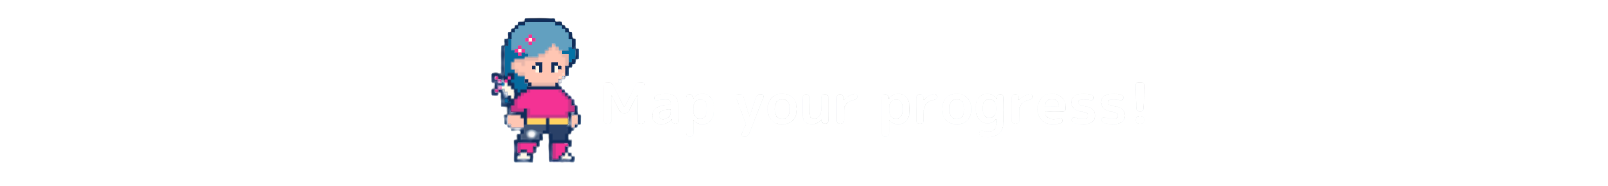

映射完成！！！天才！

**Chapter 10: VocabularyLogits: Section 2: 计算损失** <label><input type="checkbox"> 标记为完成</label>

### **Section 3 定义一个类**

🔘 **Choices**:  
`LayerNorm`　`nn.LayerNorm`　`nn.Linear`　`vocab_size`　`config.embedding_dim`

In [ ]:
class VocabularyLogits(nn.Module):
    def __init__(self, vocab_size, config):
        super().__init__()
        # 层归一化
        self.output_norm = ___________(_________________)
        # 词汇量投影
        self.vocab_projection = nn.Linear(_________________, ________)

    def forward(self, transformer_block_output):
        # 对 Transformer 块的输出应用层归一化。
        normalized_output = self.output_norm.forward(___________________)  # (B, T, C)

        # 使用线性层将输入分数映射到词汇表大小的维度。
        vocab_logits = self.vocab_projection.forward(________________)  # (B, T, V)

        return vocab_logits

<details>
<summary>点击这里显示/隐藏答案</summary>

```python
class VocabularyLogits(nn.Module):
    def __init__(self, vocab_size, config):
        super().__init__()
        # 层归一化
        self.output_norm = nn.LayerNorm(config.embedding_dim)  
        # 投影到词汇表大小
        self.vocab_projection = nn.Linear(config.embedding_dim, vocab_size)  

    def forward(self, transformer_block_output):
        # 对 Transformer 模块的输出做层归一化
        normalized_output = self.output_norm.forward(transformer_block_output)  # (B, T, C)

        # 用线性层投影输入分数到词汇表维度
        vocab_logits = self.vocab_projection.forward(normalized_output)  # (B, T, V)

        return vocab_logits
```

In [ ]:
# 我只是把目前的流程整理了一下，这样我就可以跳过它了
torch.manual_seed(1337)

# 创建一个 ModelConfig 实例。没有配置参数（构造函数）。
config = ModelConfig()

# 创建一个 EmbeddingModule 实例。
embedding_module = EmbeddingModule(vocab_size = 65, config = config)


# 创建一个 Transformer 模块实例。
transformer_block1 = TransformerBlock(config=config)
transformer_block2 = TransformerBlock(config=config)

vocab_projection_layer = # TODO: 创建 VocabularyLogits 实例。

# 与 Let's he 兼容。（批量大小，令牌长度）=（1，8）
input_tokens = torch.tensor([[24, 43, 58, 5, 57, 1, 46, 43]])
target_indices = torch.tensor([[43,  58,  5,  57,  1,   46,  43,  39]])
embeddings = embedding_module.forward(input_tokens)

# 通过第一个Transformer模块
transformer_block1_output = transformer_block1.forward(embeddings)
transformer_block2_output = transformer_block2.forward(transformer_block1_output)

vocab_logits = # TODO: 计算词汇表的logits
print_formatted_tensor("词汇预测_logits", vocab_logits)

B, T, V = vocab_logits.shape
vocab_logits_reshaped = vocab_logits.view(B * T, V)
target_labels = target_indices.view(B * T)
criterion = nn.CrossEntropyLoss()

In [ ]:
loss = criterion(vocab_logits_reshaped, target_labels)
print("损失\n", loss)

**`Check Point`** <label><input type="checkbox"> ← 如果上面的结果与下面的答案一致，请勾选此框<label>

```
loss
 tensor(3.8954, grad_fn=<NllLossBackward0>)
```

**Chapter 10: VocabularyLogits: Section 3: Define a Class** <label><input type="checkbox"> 标记为完成</label>

**Chapter 10: VocabularyLogits** <label><input type="checkbox"> Mark as Done</label>